In [1]:
import psycopg2

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

from Dataset.Embedding_Dataset import Embedding_Dataset
from Model.Embedding import Embedding

from Dataset.LSTM_Dataset import LSTM_Dataset
from Model.LSTM import LSTM
from Model.NLinear import NLinear
from Model.Transformer import Transformer

from Dataset.Attention_Dataset import Attention_Dataset
from Model.Attention import LSTMSeq2Seq


SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# DEVICE = torch.device('cpu') # CPU
# DEVICE = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu') # MAC
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # WINDOW

## Data

In [2]:
# connection_info = "host=localhost dbname=postgres user=postgres password=hd219833 port=5432"
# conn = psycopg2.connect(connection_info)
# table_1_query = '''
#     SELECT * FROM building
#     '''
# table_2_query = '''
#     SELECT * FROM economy
#     '''
# table_3_query = '''
#     SELECT * FROM building_price
#     '''
# table_1 = pd.read_sql(table_1_query,conn) 
# table_2 = pd.read_sql(table_2_query,conn)
# table_3 = pd.read_sql(table_3_query,conn) 

table_1 = pd.read_csv('../데이터/Table/table_1.csv') 
table_2 = pd.read_csv('../데이터/Table/table_2.csv') 
table_3 = pd.read_csv('../데이터/Table/table_3.csv') 

## RMSE

In [3]:
class RMSE(nn.Module):
    def __init__(self):
        super(RMSE,self).__init__()
        self.mse = nn.MSELoss()
        self.eps = 1e-7

    def forward(self, y, y_hat):
        return torch.sqrt(self.mse(y, y_hat) + self.eps)

## Plot Losses

In [4]:
def plot_train_val_losses(train_losses, val_losses):
    print(f'Min Validation Loss: {min(val_losses)}')
    plt.plot(train_losses[1:], label='Training Loss')
    plt.plot(val_losses[1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

## Early Stop

In [5]:
# val loss가 연속적으로 오를 때
def early_stop_1(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases):
    if len(val_losses) > 1 and val_losses[-1] > val_losses[-2]:
        consecutive_val_loss_increases += 1
        if consecutive_val_loss_increases >= max_consecutive_val_loss_increases:
            return True, consecutive_val_loss_increases
        else:
            return False, consecutive_val_loss_increases
    else:
        consecutive_val_loss_increases = 0
        return False, consecutive_val_loss_increases

# val loss가 최저 loss보다 연속적으로 클 때
def early_stop_2(avg_val_loss, best_val_loss, consecutive_val_loss_increases, max_consecutive_val_loss_increases):
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        consecutive_val_loss_increases = 0
    else:
        consecutive_val_loss_increases += 1
    if consecutive_val_loss_increases >= max_consecutive_val_loss_increases:
        return True, best_val_loss, consecutive_val_loss_increases
    else:
        return False, best_val_loss, consecutive_val_loss_increases

## Hyperparameters

In [6]:
train_ratio = 0.8

embedding_lr = 0.00001
embedding_weight_decay = 0
embedding_batch = 128
embedding_epochs = 150
encoder_dim_1 = 128
encoder_dim_2 = 256
encoder_dim_3 = 512
embedding_dim = 1024
decoder_dim_1 = 512
decoder_dim_2 = 256
decoder_dim_3 = 128

lstm_lr = 0.0001
lstm_weight_decay = 0
lstm_batch = 128
lstm_epochs = 150
lstm_hidden_dim = 256
lstm_window_size = 10

nlinear_lr = 0.0001
nlinear_weight_decay = 0
nlinear_batch = 128
nlinear_epochs = 150
nlinear_window_size = 10

attention_lr = 0.0001
attention_weight_decay = 0
attention_batch = 1
attention_epochs = 150
attention_hidden_dim = 256
attention_window_size = 10

transformer_lr = 0.0001
transformer_weight_decay = 0
transformer_batch = 1
transformer_epochs = 150
transformer_window_size = 10

## Embedding

In [7]:
dataset = Embedding_Dataset(table_1, table_2, table_3)
dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)

Epoch [1/150], Train Loss: 6.3301, Val Loss: 5.9672
Epoch [2/150], Train Loss: 5.8953, Val Loss: 5.6417
Epoch [3/150], Train Loss: 5.5364, Val Loss: 5.4437
Epoch [4/150], Train Loss: 5.2410, Val Loss: 5.2992
Epoch [5/150], Train Loss: 4.9869, Val Loss: 5.1627
Epoch [6/150], Train Loss: 4.7539, Val Loss: 5.0473
Epoch [7/150], Train Loss: 4.5318, Val Loss: 4.9524
Epoch [8/150], Train Loss: 4.3158, Val Loss: 4.8586
Epoch [9/150], Train Loss: 4.1043, Val Loss: 4.7725
Epoch [10/150], Train Loss: 3.8965, Val Loss: 4.6668
Epoch [11/150], Train Loss: 3.6904, Val Loss: 4.5651
Epoch [12/150], Train Loss: 3.4889, Val Loss: 4.4741
Epoch [13/150], Train Loss: 3.2935, Val Loss: 4.3737
Epoch [14/150], Train Loss: 3.1106, Val Loss: 4.2631
Epoch [15/150], Train Loss: 2.9453, Val Loss: 4.1554
Epoch [16/150], Train Loss: 2.7997, Val Loss: 4.0588
Epoch [17/150], Train Loss: 2.6745, Val Loss: 3.9656
Epoch [18/150], Train Loss: 2.5675, Val Loss: 3.8940
Epoch [19/150], Train Loss: 2.4761, Val Loss: 3.7912
Ep

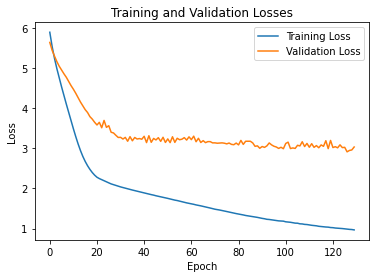

In [10]:
model = Embedding(encoder_dim_1, encoder_dim_2, encoder_dim_3, embedding_dim, decoder_dim_1, decoder_dim_2, decoder_dim_3).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(model.parameters(), lr=embedding_lr, weight_decay=embedding_weight_decay)

train_losses = []
val_losses = []
best_val_loss = float('inf')
consecutive_val_loss_increases = 0
max_consecutive_val_loss_increases = 3

for epoch in range(embedding_epochs):
    model.train()
    total_train_loss = 0
    for data in train_dataloader:
        input = data[0].to(DEVICE)
        target = data[1].to(DEVICE)
        output = model(input).to(DEVICE)

        train_loss = criterion(output, target)
        total_train_loss += train_loss.item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            input = data[0].to(DEVICE)
            target = data[1].to(DEVICE)
            output = model(input).to(DEVICE)

            val_loss = criterion(output, target)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    early_stop, consecutive_val_loss_increases = early_stop_1(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    # early_stop, best_val_loss, consecutive_val_loss_increases = early_stop_2(avg_val_loss, best_val_loss, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    if early_stop:
        print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} \nEarly Stop Triggered!')
        torch.save(model, f'../데이터/Checkpoint/embedding_tr_{train_ratio}_lr_{embedding_lr}_wd_{embedding_weight_decay}_batch_{embedding_batch}_epochs_{epoch+1}_e1_{encoder_dim_1}_e2_{encoder_dim_1}_e3_{encoder_dim_3}_emb_{embedding_dim}_d1{decoder_dim_1}_d2_{decoder_dim_2}_d3_{decoder_dim_3}.pth')
        break

    print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

plot_train_val_losses(train_losses, val_losses)

## LSTM

In [7]:
model = torch.load('../데이터/Checkpoint/embedding_tr_0.8_lr_1e-05_wd_0_batch_128_epochs_131_e1_128_e2_128_e3_512_emb_1024_d1512_d2_256_d3_128.pth')
dataset = LSTM_Dataset(model, table_1, table_2, table_3, embedding_dim, lstm_window_size, DEVICE)

dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)

Epoch [1/150], Train Loss: 3.4132, Val Loss: 3.5306
Epoch [2/150], Train Loss: 3.2753, Val Loss: 3.4851
Epoch [3/150], Train Loss: 3.2069, Val Loss: 3.4720
Epoch [4/150], Train Loss: 3.1649, Val Loss: 3.4758
Epoch [5/150], Train Loss: 3.1296, Val Loss: 3.4654
Epoch [6/150], Train Loss: 3.1009, Val Loss: 3.4549
Epoch [7/150], Train Loss: 3.0723, Val Loss: 3.4430
Epoch [8/150], Train Loss: 3.0526, Val Loss: 3.4415
Epoch [9/150], Train Loss: 3.0310, Val Loss: 3.4395
Epoch [10/150], Train Loss: 3.0113, Val Loss: 3.4461
Epoch [11/150], Train Loss: 2.9967, Val Loss: 3.4032
Epoch [12/150], Train Loss: 2.9821, Val Loss: 3.4734
Epoch [13/150], Train Loss: 2.9724, Val Loss: 3.4351
Epoch [14/150], Train Loss: 2.9668, Val Loss: 3.4177
Epoch [15/150], Train Loss: 2.9556, Val Loss: 3.4411
Epoch [16/150], Train Loss: 2.9467, Val Loss: 3.4693
Epoch [17/150], Train Loss: 2.9383, Val Loss: 3.4249
Epoch [18/150], Train Loss: 2.9398, Val Loss: 3.3901
Epoch [19/150], Train Loss: 2.9298, Val Loss: 3.4544
Ep

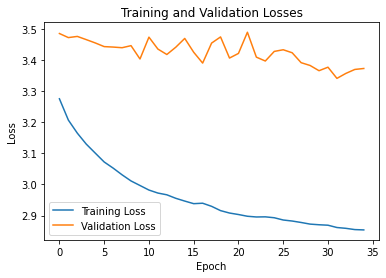

In [9]:
model = LSTM(embedding_dim, lstm_hidden_dim).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(model.parameters(), lr=lstm_lr, weight_decay=lstm_weight_decay)

train_losses = []
val_losses = []
best_val_loss = float('inf')
consecutive_val_loss_increases = 0
max_consecutive_val_loss_increases = 3

for epoch in range(lstm_epochs):
    model.train()
    total_train_loss = 0
    for data in train_dataloader:
        src = data[0].to(DEVICE)
        trg = data[1].to(DEVICE)

        if trg.sum() != 0: 
            output, _, _ = model(src)
            
            train_loss = criterion(output, trg)
            total_train_loss += train_loss.item()

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0].to(DEVICE)
            trg = data[1].to(DEVICE)

            if trg.sum() != 0:
                output, _, _ = model(src)

                val_loss = criterion(output, trg)
                total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    early_stop, consecutive_val_loss_increases = early_stop_1(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    # early_stop, best_val_loss, consecutive_val_loss_increases = early_stop_2(avg_val_loss, best_val_loss, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    if early_stop:
        print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} \nEarly Stop Triggered!')
        torch.save(model, f'../데이터/Checkpoint/lstm_tr_{train_ratio}_lr_{lstm_lr}_wd_{lstm_weight_decay}_batch_{lstm_batch}_epochs_{epoch+1}_hdim_{lstm_hidden_dim}_ws_{lstm_window_size}.pth')
        break

    print(f'Epoch [{epoch+1}/{lstm_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

plot_train_val_losses(train_losses, val_losses)

## NLinear

In [10]:
model = torch.load('../데이터/Checkpoint/embedding_tr_0.8_lr_1e-05_wd_0_batch_128_epochs_131_e1_128_e2_128_e3_512_emb_1024_d1512_d2_256_d3_128.pth')
dataset = LSTM_Dataset(model, table_1, table_2, table_3, embedding_dim, nlinear_window_size, DEVICE)

dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=nlinear_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=nlinear_batch, shuffle=False, drop_last=True)

In [11]:
model = NLinear(embedding_dim, nlinear_window_size).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(model.parameters(), lr=nlinear_lr, weight_decay=nlinear_weight_decay)

train_losses = []
val_losses = []
best_val_loss = float('inf')
consecutive_val_loss_increases = 0
max_consecutive_val_loss_increases = 3

for epoch in range(nlinear_epochs):
    model.train()
    total_train_loss = 0
    for data in train_dataloader:
        src = data[0].to(DEVICE)
        trg = data[1].to(DEVICE)

        if trg.sum() != 0:
            output = model(src)

            train_loss = criterion(output, trg)
            total_train_loss += train_loss.item()
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0].to(DEVICE)
            trg = data[1].to(DEVICE)

            if trg.sum() != 0:
                output = model(src)

                val_loss = criterion(output, trg)
                total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    early_stop, consecutive_val_loss_increases = early_stop_1(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    # early_stop, best_val_loss, consecutive_val_loss_increases = early_stop_2(avg_val_loss, best_val_loss, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    if early_stop:
        print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} \nEarly Stop Triggered!')
        torch.save(model, f'../데이터/Checkpoint/nlinear_tr_{train_ratio}_lr_{nlinear_lr}_wd_{nlinear_weight_decay}_batch_{nlinear_batch}_epochs_{epoch+1}_emb_{embedding_dim}_ws_{nlinear_window_size}.pth')
        break

    print(f'Epoch [{epoch+1}/{lstm_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

plot_train_val_losses(train_losses, val_losses)

Epoch [1/150], Train Loss: 0.3290, Val Loss: 0.2193


KeyboardInterrupt: 

## Attention

In [7]:
model = torch.load('../데이터/Checkpoint/embedding_tr_0.8_lr_1e-05_wd_0_batch_128_epochs_131_e1_128_e2_128_e3_512_emb_1024_d1512_d2_256_d3_128.pth')
dataset = Attention_Dataset(model, table_1, table_2, table_3, embedding_dim, attention_window_size)

dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=attention_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=attention_batch, shuffle=False, drop_last=True)

In [8]:
model = LSTMSeq2Seq(embedding_dim, attention_hidden_dim, 1).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(model.parameters(), lr=attention_lr, weight_decay=attention_weight_decay)

train_losses = []
val_losses = []
best_val_loss = float('inf')
consecutive_val_loss_increases = 0
max_consecutive_val_loss_increases = 3

for epoch in range(attention_epochs):
    model.train()
    total_train_loss = 0
    for data in train_dataloader:
        src = data[0][0].to(DEVICE)
        max_len = data[1][0].to(DEVICE)
        anw = data[2][0].to(DEVICE)
        trg = data[3][0].to(DEVICE)
        
        if len(anw)==0:
            continue
    
        # dong_loss = 0

        for index in anw:
            output = model(src, index, max_len)

            train_loss = criterion(output, trg[index])
            total_train_loss += train_loss.item()
            # dong_loss += loss.item()
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        # optimizer.zero_grad()
        # # dong_loss /= len(anw)
        # dong_loss = torch.tensor(dong_loss, requires_grad=True).to(DEVICE)
        # dong_loss.backward()
        # optimizer.step()
            
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0][0].to(DEVICE)
            max_len = data[1][0].to(DEVICE)
            anw = data[2][0].to(DEVICE)
            trg = data[3][0].to(DEVICE)

            if len(anw)==0:
                continue

            for index in anw:
                output = model(src, index, max_len)

                val_loss = criterion(output, trg[index])
                total_val_loss += val_loss.item()
                
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
            
    # early_stop, consecutive_val_loss_increases = early_stop_1(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    early_stop, best_val_loss, consecutive_val_loss_increases = early_stop_2(avg_val_loss, best_val_loss, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    if early_stop:
        print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} \nEarly Stop Triggered!')
        torch.save(model, f'../데이터/Checkpoint/attention_tr_{train_ratio}_lr_{attention_lr}_wd_{attention_weight_decay}_batch_{attention_batch}_epochs_{epoch+1}_hdim_{attention_hidden_dim}_ws_{attention_window_size}.pth')
        break

    print(f'Epoch [{epoch+1}/{lstm_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

plot_train_val_losses(train_losses, val_losses)

Epoch [1/150], Train Loss: 1.330557, Val Loss: 2.377012
Epoch [2/150], Train Loss: 1.180837, Val Loss: 2.293077


KeyboardInterrupt: 

## Transformer

In [9]:
model = torch.load('../데이터/Checkpoint/embedding_tr_0.8_lr_1e-05_wd_0_batch_128_epochs_131_e1_128_e2_128_e3_512_emb_1024_d1512_d2_256_d3_128.pth')
dataset = LSTM_Dataset(model, table_1, table_2, table_3, embedding_dim, transformer_window_size, DEVICE)

dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=transformer_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=transformer_batch, shuffle=False, drop_last=True)

In [10]:
model = Transformer(embedding_dim, transformer_window_size, 1, 2, 2).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(model.parameters(), lr=transformer_lr, weight_decay=transformer_weight_decay)

train_losses = []
val_losses = []
best_val_loss = float('inf')
consecutive_val_loss_increases = 0
max_consecutive_val_loss_increases = 3

for epoch in range(transformer_epochs):
    model.train()
    total_train_loss = 0
    for i, data in enumerate(train_dataloader):
        src = data[0].to(DEVICE)
        trg = data[1].to(DEVICE)

        if (trg[0] != 0):
            src_mask = model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
            output = model(src, src_mask)

            train_loss = criterion(output[0], trg[0])
            total_train_loss += train_loss.item()

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0].to(DEVICE)
            trg = data[1].to(DEVICE)

            if (trg[0] != 0):
                src_mask = model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
                output = model(src, src_mask)

                val_loss = criterion(output[0], trg[0])
                total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    early_stop, consecutive_val_loss_increases = early_stop_1(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    # early_stop, best_val_loss, consecutive_val_loss_increases = early_stop_2(avg_val_loss, best_val_loss, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    if early_stop:
        print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} \nEarly Stop Triggered!')
        torch.save(model, f'../데이터/Checkpoint/transformer_tr_{train_ratio}_lr_{transformer_lr}_wd_{transformer_weight_decay}_batch_{transformer_batch}_epochs_{epoch+1}_ws_{transformer_window_size}.pth')
        break

    print(f'Epoch [{epoch+1}/{lstm_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

plot_train_val_losses(train_losses, val_losses)

Epoch [1/150], Train Loss: 1.7742, Val Loss: 1.3610
Epoch [2/150], Train Loss: 1.0201, Val Loss: 1.1391
Epoch [3/150], Train Loss: 0.9835, Val Loss: 1.1193
Epoch [4/150], Train Loss: 0.9828, Val Loss: 1.1159
Epoch [5/150], Train Loss: 0.9828, Val Loss: 1.1152
Epoch [6/150], Train Loss: 0.9828, Val Loss: 1.1150
Epoch [7/150], Train Loss: 0.9828, Val Loss: 1.1150
Epoch [8/150], Train Loss: 0.9828, Val Loss: 1.1150
Epoch [9/150], Train Loss: 0.9828, Val Loss: 1.1150
Epoch [10/150], Train Loss: 0.9828, Val Loss: 1.1150
Epoch [11/150], Train Loss: 0.9828, Val Loss: 1.1150
Epoch [12/150], Train Loss: 0.9828, Val Loss: 1.1150
Epoch [13/150], Train Loss: 0.9828, Val Loss: 1.1150
Epoch [14/150], Train Loss: 0.9828, Val Loss: 1.1150
Epoch [15/150], Train Loss: 0.9828, Val Loss: 1.1150
Epoch [16/150], Train Loss: 0.9828, Val Loss: 1.1150
Epoch [17/150], Train Loss: 0.9828, Val Loss: 1.1150
Epoch [18/150], Train Loss: 0.9828, Val Loss: 1.1150
